<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#前処理" data-toc-modified-id="前処理-0.1" data-vivaldi-spatnav-clickable="1">前処理</a></span><ul class="toc-item"><li><span><a href="#データセット読み込みと文字IDベクトルへの変換" data-toc-modified-id="データセット読み込みと文字IDベクトルへの変換-0.1.1" data-vivaldi-spatnav-clickable="1">データセット読み込みと文字IDベクトルへの変換</a></span></li></ul></li><li><span><a href="#転移元のデータセットで学習" data-toc-modified-id="転移元のデータセットで学習-0.2" data-vivaldi-spatnav-clickable="1">転移元のデータセットで学習</a></span><ul class="toc-item"><li><span><a href="#ハイパーパラメータ設定とデータ前処理" data-toc-modified-id="ハイパーパラメータ設定とデータ前処理-0.2.1" data-vivaldi-spatnav-clickable="1">ハイパーパラメータ設定とデータ前処理</a></span></li><li><span><a href="#model,-optimizer,-trainerインスタンス作成" data-toc-modified-id="model,-optimizer,-trainerインスタンス作成-0.2.2" data-vivaldi-spatnav-clickable="1">model, optimizer, trainerインスタンス作成</a></span></li><li><span><a href="#学習実行" data-toc-modified-id="学習実行-0.2.3" data-vivaldi-spatnav-clickable="1">学習実行</a></span></li><li><span><a href="#パラメータ保存" data-toc-modified-id="パラメータ保存-0.2.4" data-vivaldi-spatnav-clickable="1">パラメータ保存</a></span></li></ul></li></ul></li><li><span><a href="#転移学習" data-toc-modified-id="転移学習-1" data-vivaldi-spatnav-clickable="1">転移学習</a></span><ul class="toc-item"><li><span><a href="#推論" data-toc-modified-id="推論-1.1" data-vivaldi-spatnav-clickable="1">推論</a></span></li><li><span><a href="#結果の保存" data-toc-modified-id="結果の保存-1.2" data-vivaldi-spatnav-clickable="1">結果の保存</a></span></li></ul></li><li><span><a href="#確信度の取得" data-toc-modified-id="確信度の取得-2" data-vivaldi-spatnav-clickable="1">確信度の取得</a></span></li></ul></div>

# 転移学習

ディレクトリ構成：  
```
./
├train_seq2seq_transfer-learning.ipynb(このファイル)
├model/
│   └(モデルパラメータキャッシュファイル)
├dataset/
│   └(読み込むCSVファイル)
├result/
│   └(実行結果CSVと学習曲線グラフ画像)
└src/
   ├common/
   │ └(共用クラス、関数)
   ├data/
   │ └(データ読み書き用コード)
   ├attention_layer.py
   ├attention_seq2seq.py
   ├peeky_seq2seq.py
   └seq2seq.py
```

In [612]:
# 変数の全消去
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
# coding: utf-8
import sys
sys.path.append("./src")
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from data.sequence import TextSequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq
from attention_seq2seq import AttentionSeq2seq

In [2]:
# matplotlibのインライン表示
%matplotlib inline
# モジュールの更新時に自動で再読み込み
%reload_ext autoreload
%autoreload 2

In [3]:
# ファイルパスの設定
dataset_dir =Path('./dataset')
result_dir = Path('./result')
model_dir = Path('./model')
target_csv = dataset_dir / "interpretation_train43_and_test40.csv"
pre_train_csv = dataset_dir / "interpretation_excel_concat_trim.csv"
dataset_name = target_csv.stem
encoding = "utf-8"

### 前処理
#### データセット読み込みと文字IDベクトルへの変換

転移学習のため、最初にデータセットを2つ読み込んで統合したボキャブラリーリストを作成する

In [4]:
# 両方のデータセットを読み、統合したボキャブラリーリストを作成する
seq = TextSequence()
seq.read_csv(target_csv, vocab_init=False)
seq.read_csv(pre_train_csv, vocab_init=False)
char_to_id, id_to_char = seq.vocab

In [5]:
len(char_to_id)

433

### 転移元のデータセットで学習

#### ハイパーパラメータ設定とデータ前処理

In [6]:
# ハイパーパラメータ
vocab_size = len(char_to_id)
wordvec_size = 128
hidden_size = 128
batch_size = 32
max_epoch = 100
max_grad = 5.0

In [7]:
# データセット分割
x_train, x_test, t_train, t_test = seq.split_data(seed=1, test_size=0.1)

#### model, optimizer, trainerインスタンス作成

In [8]:
# モデル選択
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)

In [9]:
# OptimizerとTrainerインスタンスの初期化
optimizer = Adam()
trainer = Trainer(model, optimizer)

#### 学習実行

In [10]:
# Train
trainer.fit(x_train, t_train, x_test, t_test,
            max_epoch=max_epoch,
            batch_size=batch_size,
            max_grad=max_grad)

| epoch 1 |  iter 1 / 19 | time 0[s] | loss 6.07
| epoch 1 | loss 6.06940
| epoch 1 | train error 1.00000
| epoch 1 | test error  1.00000
| epoch 2 |  iter 1 / 19 | time 5[s] | loss 4.79
| epoch 2 | loss 4.78737
| epoch 2 | train error 1.00000
| epoch 2 | test error  1.00000
| epoch 3 |  iter 1 / 19 | time 10[s] | loss 2.68
| epoch 3 | loss 2.67967
| epoch 3 | train error 1.00000
| epoch 3 | test error  1.00000
| epoch 4 |  iter 1 / 19 | time 15[s] | loss 2.25
| epoch 4 | loss 2.25108
| epoch 4 | train error 1.00000
| epoch 4 | test error  1.00000
| epoch 5 |  iter 1 / 19 | time 20[s] | loss 2.00
| epoch 5 | loss 1.99654
| epoch 5 | train error 1.00000
| epoch 5 | test error  1.00000
| epoch 6 |  iter 1 / 19 | time 25[s] | loss 1.82
| epoch 6 | loss 1.82181
| epoch 6 | train error 1.00000
| epoch 6 | test error  1.00000
| epoch 7 |  iter 1 / 19 | time 30[s] | loss 1.70
| epoch 7 | loss 1.70132
| epoch 7 | train error 1.00000
| epoch 7 | test error  1.00000
| epoch 8 |  iter 1 / 19 | ti

| epoch 58 | loss 0.06856
| epoch 58 | train error 0.38312
| epoch 58 | test error  0.52174
| epoch 59 |  iter 1 / 19 | time 302[s] | loss 0.07
| epoch 59 | loss 0.06574
| epoch 59 | train error 0.33117
| epoch 59 | test error  0.49275
| epoch 60 |  iter 1 / 19 | time 307[s] | loss 0.06
| epoch 60 | loss 0.06433
| epoch 60 | train error 0.33442
| epoch 60 | test error  0.53623
| epoch 61 |  iter 1 / 19 | time 313[s] | loss 0.06
| epoch 61 | loss 0.05808
| epoch 61 | train error 0.35065
| epoch 61 | test error  0.52174
| epoch 62 |  iter 1 / 19 | time 318[s] | loss 0.06
| epoch 62 | loss 0.05728
| epoch 62 | train error 0.30682
| epoch 62 | test error  0.40580
| epoch 63 |  iter 1 / 19 | time 323[s] | loss 0.06
| epoch 63 | loss 0.05621
| epoch 63 | train error 0.36039
| epoch 63 | test error  0.50725
| epoch 64 |  iter 1 / 19 | time 328[s] | loss 0.05
| epoch 64 | loss 0.05476
| epoch 64 | train error 0.29870
| epoch 64 | test error  0.47826
| epoch 65 |  iter 1 / 19 | time 333[s] | lo

#### パラメータ保存

In [11]:
# 保存ファイルのファイル名生成
modelname = model.__class__.__name__
timestamp = datetime.now().strftime("_%y%m%d_%H%M")

In [12]:
# Save parameters
pickle_path = model_dir / (pre_train_csv.stem + "_" + modelname + '_V' + str(vocab_size) + '_D' + str(wordvec_size) + '_H' + str(hidden_size) + timestamp + '.pkl')
model.save_params(file_name=pickle_path)

## 転移学習

In [13]:
# データセット読み込み
seq.read_csv(target_csv, vocab_init=False)

(array([[ 1,  2,  3, ...,  0,  0,  0],
        [ 1,  2, 13, ...,  0,  0,  0],
        [ 1,  2, 13, ...,  0,  0,  0],
        ...,
        [62, 14, 23, ...,  0,  0,  0],
        [62, 14, 23, ...,  0,  0,  0],
        [14,  8, 20, ...,  0,  0,  0]]), array([[12,  1,  2, ...,  0,  0,  0],
        [12,  1,  2, ...,  0,  0,  0],
        [12,  1,  2, ...,  0,  0,  0],
        ...,
        [12, 14, 62, ...,  0,  0,  0],
        [12, 14, 62, ...,  0,  0,  0],
        [12, 10, 76, ...,  0,  0,  0]]))

In [14]:
# データセット分割
x_train, x_test, t_train, t_test = seq.split_data(seed=1, test_size=0.1)

In [15]:
# モデル選択
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

In [17]:
model.load_params(file_name=str(pickle_path))

In [18]:
# OptimizerとTrainerインスタンスの初期化
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [19]:
# Train
trainer.fit(x_train, t_train, x_test, t_test,
            max_epoch=max_epoch,
            batch_size=batch_size,
            max_grad=max_grad)

| epoch 1 |  iter 1 / 28 | time 0[s] | loss 1.44
| epoch 1 |  iter 21 / 28 | time 5[s] | loss 0.54
| epoch 1 | loss 0.54239
| epoch 1 | train error 0.81114
| epoch 1 | test error  0.78431
| epoch 2 |  iter 1 / 28 | time 10[s] | loss 0.28
| epoch 2 |  iter 21 / 28 | time 14[s] | loss 0.25
| epoch 2 | loss 0.24520
| epoch 2 | train error 0.74236
| epoch 2 | test error  0.70588
| epoch 3 |  iter 1 / 28 | time 20[s] | loss 0.23
| epoch 3 |  iter 21 / 28 | time 24[s] | loss 0.18
| epoch 3 | loss 0.17904
| epoch 3 | train error 0.61245
| epoch 3 | test error  0.60784
| epoch 4 |  iter 1 / 28 | time 30[s] | loss 0.16
| epoch 4 |  iter 21 / 28 | time 34[s] | loss 0.14
| epoch 4 | loss 0.14096
| epoch 4 | train error 0.48581
| epoch 4 | test error  0.44118
| epoch 5 |  iter 1 / 28 | time 40[s] | loss 0.13
| epoch 5 |  iter 21 / 28 | time 45[s] | loss 0.11
| epoch 5 | loss 0.11419
| epoch 5 | train error 0.45415
| epoch 5 | test error  0.38235
| epoch 6 |  iter 1 / 28 | time 50[s] | loss 0.12
| 

| epoch 43 |  iter 1 / 28 | time 422[s] | loss 0.01
| epoch 43 |  iter 21 / 28 | time 427[s] | loss 0.01
| epoch 43 | loss 0.00992
| epoch 43 | train error 0.09170
| epoch 43 | test error  0.15686
| epoch 44 |  iter 1 / 28 | time 432[s] | loss 0.01
| epoch 44 |  iter 21 / 28 | time 437[s] | loss 0.01
| epoch 44 | loss 0.00988
| epoch 44 | train error 0.09498
| epoch 44 | test error  0.10784
| epoch 45 |  iter 1 / 28 | time 442[s] | loss 0.01
| epoch 45 |  iter 21 / 28 | time 447[s] | loss 0.01
| epoch 45 | loss 0.00924
| epoch 45 | train error 0.09061
| epoch 45 | test error  0.11765
| epoch 46 |  iter 1 / 28 | time 452[s] | loss 0.01
| epoch 46 |  iter 21 / 28 | time 457[s] | loss 0.01
| epoch 46 | loss 0.00923
| epoch 46 | train error 0.09170
| epoch 46 | test error  0.13725
| epoch 47 |  iter 1 / 28 | time 462[s] | loss 0.01
| epoch 47 |  iter 21 / 28 | time 468[s] | loss 0.01
| epoch 47 | loss 0.00857
| epoch 47 | train error 0.08624
| epoch 47 | test error  0.11765
| epoch 48 |  i

| epoch 84 | train error 0.08406
| epoch 84 | test error  0.11765
| epoch 85 |  iter 1 / 28 | time 845[s] | loss 0.01
| epoch 85 |  iter 21 / 28 | time 850[s] | loss 0.01
| epoch 85 | loss 0.00593
| epoch 85 | train error 0.08515
| epoch 85 | test error  0.13725
| epoch 86 |  iter 1 / 28 | time 855[s] | loss 0.01
| epoch 86 |  iter 21 / 28 | time 860[s] | loss 0.01
| epoch 86 | loss 0.00561
| epoch 86 | train error 0.08515
| epoch 86 | test error  0.14706
| epoch 87 |  iter 1 / 28 | time 865[s] | loss 0.01
| epoch 87 |  iter 21 / 28 | time 870[s] | loss 0.01
| epoch 87 | loss 0.00614
| epoch 87 | train error 0.08624
| epoch 87 | test error  0.13725
| epoch 88 |  iter 1 / 28 | time 875[s] | loss 0.01
| epoch 88 |  iter 21 / 28 | time 880[s] | loss 0.01
| epoch 88 | loss 0.00572
| epoch 88 | train error 0.08406
| epoch 88 | test error  0.12745
| epoch 89 |  iter 1 / 28 | time 885[s] | loss 0.01
| epoch 89 |  iter 21 / 28 | time 890[s] | loss 0.01
| epoch 89 | loss 0.00595
| epoch 89 | tr

### 推論

In [18]:
# Inference
start_id = seq.start_id
sample_size = seq.t_length
guess_train = model.generate(x_train, start_id, sample_size)
guess_test = model.generate(x_test, start_id, sample_size)

### 結果の保存

In [19]:
# 保存ファイルのファイル名生成
modelname = model.__class__.__name__
timestamp = datetime.now().strftime("_%y%m%d_%H%M")
save_dir = result_dir / ("transfer" + timestamp)
os.makedirs(save_dir, exist_ok=True)

In [20]:
# Save result as csv
result_train_csv = save_dir /  ("result_transfer_" + modelname + "_train.csv")
result_test_csv = save_dir / ("result_transfer_" + modelname + "_test.csv")
df_result_train = seq.result_to_csv(result_train_csv, x_train, t_train, guess_train, encoding=encoding)
df_result_test = seq.result_to_csv(result_test_csv, x_test, t_test, guess_test, encoding=encoding)

Accuracy: 0.9967532467532467
Accuracy: 0.782608695652174


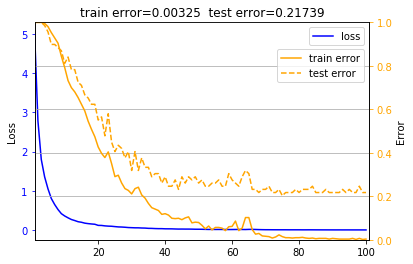

In [21]:
# Plot learning curve and save it as png image
image_path = save_dir / ('result_transfer_' + modelname + '.png')
trainer.plot(image_path=image_path)

In [22]:
# Save parameters
pickle_path = model_dir / ("transfer_" + modelname + '_V' + str(vocab_size) + '_D' + str(wordvec_size) + '_H' + str(hidden_size) + timestamp + '.pkl')
model.save_params(file_name=pickle_path)

## 確信度の取得

In [177]:
model.load_params(file_name=str(pickle_path))

In [484]:
# Inference with certainty factor
start_id = seq.start_id
sample_size = seq.t_length
guess_train, cf_train = model.generate_with_cf(x_train, start_id, sample_size)
guess_test, cf_test = model.generate_with_cf(x_test, start_id, sample_size)

In [485]:
# 保存ファイルのファイル名生成
modelname = model.__class__.__name__
timestamp = datetime.now().strftime("_%y%m%d_%H%M")
save_dir = result_dir / (dataset_name + timestamp)
os.makedirs(save_dir, exist_ok=True)

In [488]:
# Save result as csv
result_train_csv = save_dir /  ("result_" + dataset_name + "_" + modelname + "_train.csv")
result_test_csv = save_dir / ("result_" + dataset_name + "_" + modelname + "_test.csv")
df_result_train = seq.result_to_csv(result_train_csv, x_train, t_train, guess_train, cf=cf_train, encoding=encoding)
df_result_test = seq.result_to_csv(result_test_csv, x_test, t_test, guess_test, cf=cf_test, encoding=encoding)

Accuracy: 0.898471615720524
Accuracy: 0.8627450980392157


In [109]:
def cf_filter(df):
    for factor in np.arange(0.90, 1.00, 0.01):
        print("cf={:.2f}".format(factor))
        print(" correct   :", df.query('correct == 1 and cf < {}'.format(factor)).shape[0])
        print(" incorrect :", df.query('correct == 0 and cf < {}'.format(factor)).shape[0])

In [342]:
cf_filter(df_result_train)

cf=0.90
 correct   : 4
 incorrect : 5
cf=0.91
 correct   : 4
 incorrect : 5
cf=0.92
 correct   : 5
 incorrect : 5
cf=0.93
 correct   : 7
 incorrect : 7
cf=0.94
 correct   : 7
 incorrect : 7
cf=0.95
 correct   : 12
 incorrect : 16
cf=0.96
 correct   : 19
 incorrect : 20
cf=0.97
 correct   : 40
 incorrect : 30
cf=0.98
 correct   : 93
 incorrect : 56
cf=0.99
 correct   : 223
 incorrect : 80


In [277]:
cf_filter(df_result_test)

cf=0.90
 correct   : 0
 incorrect : 0
cf=0.91
 correct   : 0
 incorrect : 0
cf=0.92
 correct   : 0
 incorrect : 0
cf=0.93
 correct   : 0
 incorrect : 0
cf=0.94
 correct   : 0
 incorrect : 0
cf=0.95
 correct   : 0
 incorrect : 0
cf=0.96
 correct   : 0
 incorrect : 0
cf=0.97
 correct   : 0
 incorrect : 0
cf=0.98
 correct   : 0
 incorrect : 0
cf=0.99
 correct   : 88
 incorrect : 14


In [430]:
corrects = df_result_train['correct'].value_counts()
corrects

1    823
0     93
Name: correct, dtype: int64

In [196]:
def accuracy(df, cf):
    df_passed = df.query('cf > {}'.format(cf))
    if len(df_passed) > 0:
        nb_corrects = df_passed['correct'].value_counts()[1]
        return nb_corrects / len(df_passed)
    else:
        return 0

In [135]:
def passing_rate(df, cf):
    nb_passing = len(df.query('cf >= {}'.format(cf)))
    return nb_passing / len(df)

In [526]:
accuracy(df_result_test, 0.992)

0.9827586206896551

In [527]:
passing_rate(df_result_test, 0.992)

0.5686274509803921

In [489]:
def accuracy_by_cf(df):
    acc_list = []
    pr_list = []
    for cf in np.arange(0.90, 1.00, 0.001):
#         print("cf={:.2f}".format(cf))
        acc = accuracy(df, cf)
        pr  = passing_rate(df, cf)
#         print("  Accuracy     :", acc)
#         print("  Passing rate :", pr)
        acc_list.append(acc)
        pr_list.append(pr)
    return acc_list, pr_list

In [490]:
acc_train, pr_train = accuracy_by_cf(df_result_train)

In [491]:
acc_test, pr_test = accuracy_by_cf(df_result_test)

[]

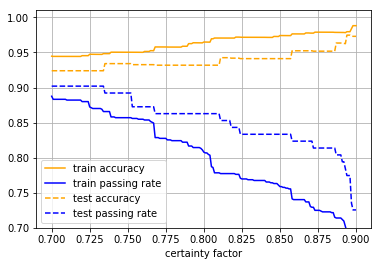

In [469]:
x = np.arange(0.90, 1.00, 0.001)
fig, ax = plt.subplots()
color_acc = 'orange'
color_pr = 'blue'
ax.plot(x, acc_train, color=color_acc, label='train accuracy')
ax.plot(x, pr_train, color=color_pr, label='train passing rate')
ax.plot(x, acc_test, color=color_acc, linestyle='dashed', label='test accuracy')
ax.plot(x, pr_test, color=color_pr, linestyle='dashed', label='test passing rate')
ax.grid(True)
plt.xlabel('certainty factor')
ax.set_ylim(0.7, 1.01)
ax.legend()
plt.savefig('./accuracy_and_passing-rate.png')
plt.plot()